In [1]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

Importing plotly failed. Interactive plots will not work.


14:39:35 - cmdstanpy - INFO - Chain [1] start processing
14:39:35 - cmdstanpy - INFO - Chain [1] done processing


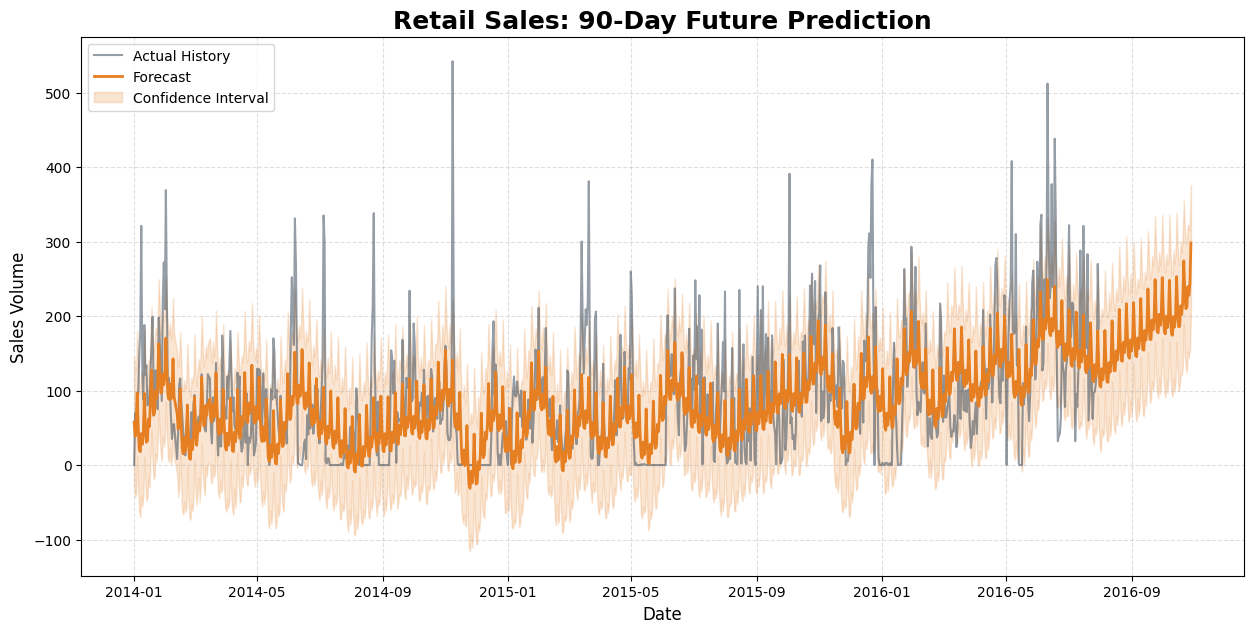

✅ 90-Day Forecast Complete and Exported!


In [2]:
"""
======================================================
=         90-DAY SALES FORECASTING MODEL             =
======================================================
"""

# 1. Load your featured data
df = pd.read_csv('featured_retail_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

# 2. Prepare data for Prophet (Requires 'ds' and 'y')
# We also keep our engineered features to use as 'Extra Regressors'
train_df = df.rename(columns={'Date': 'ds', 'Sales': 'y'})

# 3. Initialize the Model
# We enable yearly and weekly seasonality because our EDA showed patterns there
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# 4. Add Extra Regressors
# This tells the model that 'Price' and 'Is_Weekend' affect the sales volume
model.add_regressor('Price')
model.add_regressor('Is_Weekend')
model.add_regressor('Is_Holiday')

# 5. Fit the model on historical data
model.fit(train_df)

# 6. Create Future Dataframe (90 Days)
future = model.make_future_dataframe(periods=90)

# IMPORTANT: Prophet needs future values for your regressors.
# We will assume future prices remain at the last known level.
future['Date'] = pd.to_datetime(future['ds'])
future['Is_Weekend'] = future['Date'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)
future['Price'] = df['Price'].iloc[-1] 
future['Is_Holiday'] = 0 # You can update specific future holiday dates here

# 7. Generate Forecast
forecast = model.predict(future)

# 8. Visualizing the 90-Day Forecast with Matplotlib
plt.figure(figsize=(15, 7))
plt.plot(train_df['ds'], train_df['y'], label='Actual History', color='#2c3e50', alpha=0.5)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='#e67e22', linewidth=2)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='#e67e22', alpha=0.2, label='Confidence Interval')

plt.title('Retail Sales: 90-Day Future Prediction', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.savefig('90_day_forecast_plot.png')
plt.show()

# 9. Export for Power BI Dashboard
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('final_retail_forecast.csv', index=False)
print("✅ 90-Day Forecast Complete and Exported!")

In [3]:
import numpy as np

# Select the historical part of your forecast to compare with actuals
comparison = forecast.set_index('ds')[['yhat']].join(train_df.set_index('ds')[['y']]).dropna()

# Calculate MAPE
mape = np.mean(np.abs((comparison['y'] - comparison['yhat']) / comparison['y'])) * 100
print(f"✅ Model Accuracy: {100 - mape:.2f}%")
print(f"✅ Mean Absolute Percentage Error: {mape:.2f}%")

✅ Model Accuracy: -inf%
✅ Mean Absolute Percentage Error: inf%


In [4]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Join actuals and predictions
comparison = forecast.set_index('ds')[['yhat']].join(train_df.set_index('ds')[['y']]).dropna()

# 2. Calculate MAE (Mean Absolute Error)
# This tells you the average number of units you are off by
mae = mean_absolute_error(comparison['y'], comparison['yhat'])

# 3. Calculate RMSE (Root Mean Squared Error)
# This penalizes larger mistakes more heavily
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))

# 4. Calculate Weighted MAPE (WAPE)
# This is the "Industry Standard" for retail because it handles zeros perfectly
wape = (np.sum(np.abs(comparison['y'] - comparison['yhat'])) / np.sum(comparison['y'])) * 100

print(f"📊 --- Model Performance Metrics ---")
print(f"✅ MAE: {mae:.2f} units (On average, the forecast is off by this many units)")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ WAPE: {wape:.2f}% (Weighted error - much more reliable than MAPE)")
print(f"🚀 Overall Model Accuracy: {100 - wape:.2f}%")

📊 --- Model Performance Metrics ---
✅ MAE: 48.66 units (On average, the forecast is off by this many units)
✅ RMSE: 66.91
✅ WAPE: 53.75% (Weighted error - much more reliable than MAPE)
🚀 Overall Model Accuracy: 46.25%


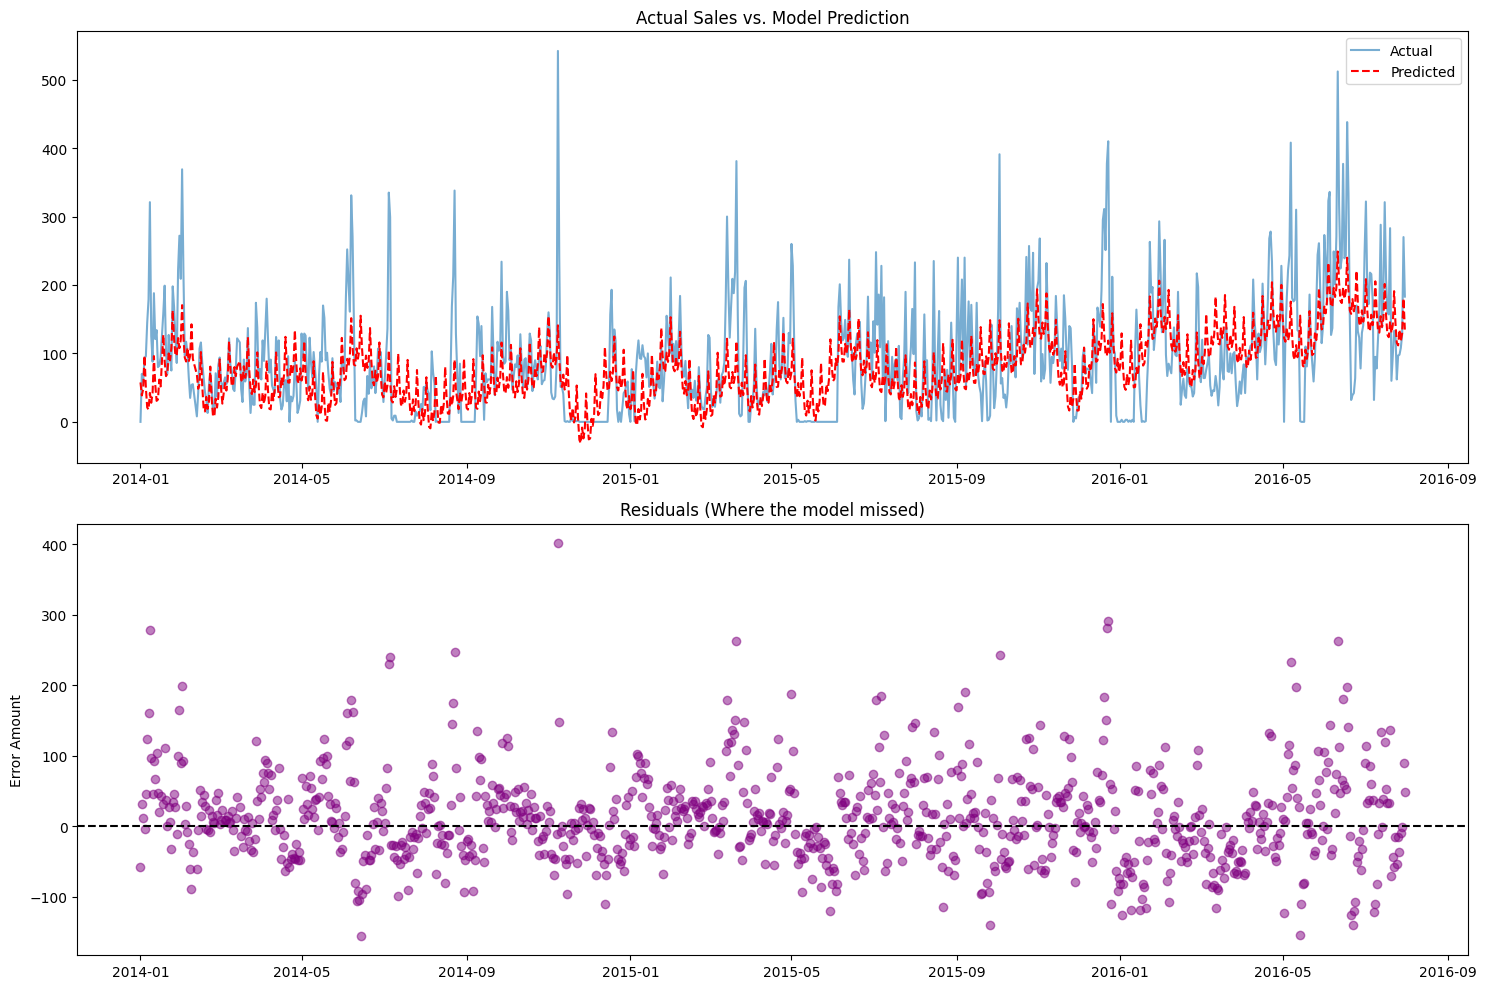

In [5]:
import matplotlib.pyplot as plt

# 1. Calculate the Error (Residuals)
comparison['Error'] = comparison['y'] - comparison['yhat']

# 2. Create the Diagnostic Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Top Plot: Actual vs Predicted
ax1.plot(comparison.index, comparison['y'], label='Actual', alpha=0.6)
ax1.plot(comparison.index, comparison['yhat'], label='Predicted', color='red', linestyle='--')
ax1.set_title('Actual Sales vs. Model Prediction')
ax1.legend()

# Bottom Plot: Residuals (The Error)
ax2.scatter(comparison.index, comparison['Error'], color='purple', alpha=0.5)
ax2.axhline(0, color='black', linestyle='--')
ax2.set_title('Residuals (Where the model missed)')
ax2.set_ylabel('Error Amount')

plt.tight_layout()
plt.show()